**Deteksi Objek Pada Sel Malaria menggunakan Faster R-CNN**

**Visi Komputer | IF-42-GAB**

1.   Reynaldi Prama Octavially | 1301208569
2.   Rizky Asep Sutrisna | 1301208600

**FASTER R-CNN**

**IMAGE ANALYSIS**

**Import library yang dibutuhkan**

In [38]:
# Menghubungkan ke google drive untuk mengambil data dan file yang dibutuhkan
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Import library yang akan digunakan
import numpy as np
import time
import sys
import os
import random
import pandas as pd
import cv2
import tensorflow as tf

from matplotlib import pyplot as plt
from shutil import copyfile

**Konversi data train dan test yang sebelumnya dalam format json menjadi csv**

In [40]:
import json
import csv

# Membaca file JSON dari google drive
with open('drive/MyDrive/Visi Komputer/train.json', 'r') as myfile:
    data=myfile.read()

objlist = json.loads(data)
_list = []
for obj in objlist:
        _imageRow = []
        img = obj['image']
        _imageRow.append(img['checksum'])
        _imageRow.append(img['pathname'])
        shp = img['shape']
        _imageRow.append(shp['r'])
        _imageRow.append(shp['c'])
        _imageRow.append(shp['channels'])

        boundObjs = obj['objects']
        for boundObj in boundObjs:
            _bondBox = []
            
            bbox = boundObj['bounding_box']
            bmin = bbox['minimum']
            _bondBox.append(bmin['r'])
            _bondBox.append(bmin['c'])
            
            bmax = bbox['maximum']
            _bondBox.append(bmax['r'])
            _bondBox.append(bmax['c'])
            _bondBox.append(boundObj['category'])
            
            _newRow = []
            for r in _imageRow:
                _newRow.append(r)
            for r in _bondBox:        
                _newRow.append(r)
            _bondBox.remove
            _list.append(_newRow)
        _imageRow.remove            

# Membuat file CSV
with open('drive/MyDrive/Visi Komputer/train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['checksum', 'pathname', 'shapeR' , 'shapeC', 'channels', 'bbminR', 'bbminC', 'bbmaxR', 'bbmaxC', 'category'])
    writer.writerows(_list)

In [41]:
import json
import csv

# Membaca file JSON dari google drive
with open('drive/MyDrive/Visi Komputer/test.json', 'r') as myfile:
    data=myfile.read()

# parse file
objlist = json.loads(data)
_list = []
for obj in objlist:
        _imageRow = []
        img = obj['image']
        _imageRow.append(img['checksum'])
        _imageRow.append(img['pathname'])
        shp = img['shape']
        _imageRow.append(shp['r'])
        _imageRow.append(shp['c'])
        _imageRow.append(shp['channels'])

        boundObjs = obj['objects']
        for boundObj in boundObjs:
            _bondBox = []
            
            bbox = boundObj['bounding_box']
            bmin = bbox['minimum']
            _bondBox.append(bmin['r'])
            _bondBox.append(bmin['c'])
            
            bmax = bbox['maximum']
            _bondBox.append(bmax['r'])
            _bondBox.append(bmax['c'])
            _bondBox.append(boundObj['category'])
            
            _newRow = []
            for r in _imageRow:
                _newRow.append(r)
            for r in _bondBox:        
                _newRow.append(r)
            _bondBox.remove
            _list.append(_newRow)
        _imageRow.remove  

# Membuat file CSV
with open('drive/MyDrive/Visi Komputer/test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['checksum', 'pathname', 'shapeR' , 'shapeC', 'channels', 'bbminR', 'bbminC', 'bbmaxR', 'bbmaxC', 'category'])
    writer.writerows(_list)

**Analisis Data**

In [42]:
# Melihat data train yang sudah dalam format CSV
train = pd.read_csv("drive/MyDrive/Visi Komputer/train.csv")
print("Kolom", train.columns)
print("Ukuran", train.shape)

Kolom Index(['checksum', 'pathname', 'shapeR', 'shapeC', 'channels', 'bbminR',
       'bbminC', 'bbmaxR', 'bbmaxC', 'category'],
      dtype='object')
Ukuran (80113, 10)


In [43]:
# Melihat data test yang sudah dalam format CSV
test = pd.read_csv("drive/MyDrive/Visi Komputer/test.csv")
print("Kolom", test.columns)
print("Ukuran", test.shape)

Kolom Index(['checksum', 'pathname', 'shapeR', 'shapeC', 'channels', 'bbminR',
       'bbminC', 'bbmaxR', 'bbmaxC', 'category'],
      dtype='object')
Ukuran (5922, 10)


In [44]:
# Melihat 10 data teratas dari data train
print(train.head(10))

                           checksum  \
0  676bb8e86fc2dbf05dd97d51a64ac0af   
1  676bb8e86fc2dbf05dd97d51a64ac0af   
2  676bb8e86fc2dbf05dd97d51a64ac0af   
3  676bb8e86fc2dbf05dd97d51a64ac0af   
4  676bb8e86fc2dbf05dd97d51a64ac0af   
5  676bb8e86fc2dbf05dd97d51a64ac0af   
6  676bb8e86fc2dbf05dd97d51a64ac0af   
7  676bb8e86fc2dbf05dd97d51a64ac0af   
8  676bb8e86fc2dbf05dd97d51a64ac0af   
9  676bb8e86fc2dbf05dd97d51a64ac0af   

                                           pathname  shapeR  shapeC  channels  \
0  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
1  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
2  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
3  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
4  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
5  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
6  

In [45]:
# Melihat 10 data teratas dari data test
print(test.head(10))

                           checksum  \
0  eea3bfd6a929bcb06f9786667cd3fbb2   
1  eea3bfd6a929bcb06f9786667cd3fbb2   
2  eea3bfd6a929bcb06f9786667cd3fbb2   
3  eea3bfd6a929bcb06f9786667cd3fbb2   
4  eea3bfd6a929bcb06f9786667cd3fbb2   
5  eea3bfd6a929bcb06f9786667cd3fbb2   
6  eea3bfd6a929bcb06f9786667cd3fbb2   
7  eea3bfd6a929bcb06f9786667cd3fbb2   
8  eea3bfd6a929bcb06f9786667cd3fbb2   
9  eea3bfd6a929bcb06f9786667cd3fbb2   

                                           pathname  shapeR  shapeC  channels  \
0  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
1  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
2  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
3  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
4  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
5  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
6  

**Kategori Data**

In [46]:
# Melihat banyak data dari masing-masing kategori
print(train['category'].value_counts())

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: category, dtype: int64


In [47]:
# Melihat banyak data dari masing-masing kategori
print(test['category'].value_counts())

red blood cell    5614
ring               169
trophozoite        111
gametocyte          12
schizont            11
difficult            5
Name: category, dtype: int64


**Analisis Gambar**

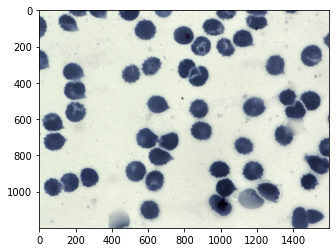

In [48]:
# Mengambil gambar yang akan digunakan untuk train
image = plt.imread('drive/MyDrive/Visi Komputer/Images/train_images.png')
plt.imshow(image)
plt.show()

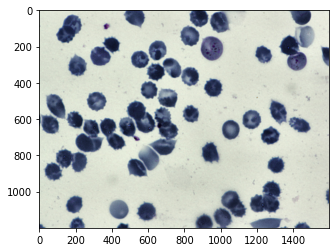

In [52]:
# Mengambil gambar yang akan digunakan untuk train
image = plt.imread('drive/MyDrive/Visi Komputer/Images/train_images_dua.png')
plt.imshow(image)
plt.show()

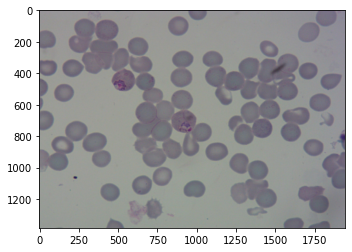

In [53]:
# Mengambil gambar yang digunakan untuk test
image = plt.imread('drive/MyDrive/Visi Komputer/Images/test_images.jpg')
plt.imshow(image)
plt.show()

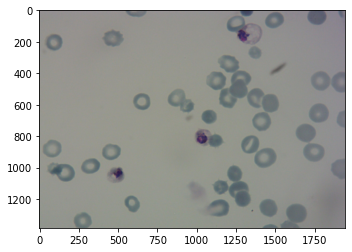

In [54]:
# Mengambil gambar yang digunakan untuk test
image = plt.imread('drive/MyDrive/Visi Komputer/Images/test_images_dua.jpg')
plt.imshow(image)
plt.show()

**Analisis Gambar Menggunakan Bounding Box**

In [55]:
import matplotlib.patches as patches

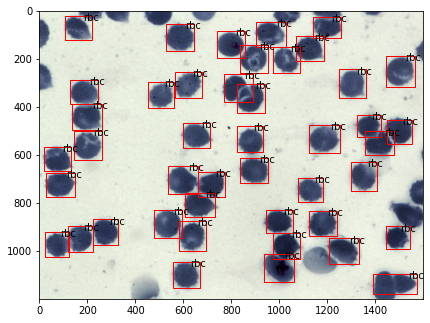

In [56]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

# Membaca gambar train dari google drive
image = plt.imread('drive/MyDrive/Visi Komputer/Images/train_images.png')
plt.imshow(image)

# Menggunakan data dalam train.csv
for _,row in train[train.pathname=="/images/00a02700-2ea2-4590-9e15-ffc9160fd3de.png"].iterrows():
    xmin = row.bbminC
    xmax = row.bbmaxC
    ymin = row.bbminR
    ymax = row.bbmaxR
    
    l = xmax-xmin
    b = ymax-ymin
           
    if row.category=='red blood cell':
      color='r'
      ax.annotate('rbc',xy=(xmax-40,ymin+20))
    elif row.category=='trophozoite':
      color='g'
      ax.annotate('trpz',xy=(xmax-40,ymin+20))
    elif row.category=='difficult':
      color='b'
      ax.annotate('dfct',xy=(xmax-40,ymin+20))
    elif row.category=='ring':
      color='r'
      ax.annotate('ring',xy=(xmax-40,ymin+20))
    elif row.category=='schizont':
      color='r'
      ax.annotate('sznt',xy=(xmax-40,ymin+20))
    elif row.category==6:
      color='gametocyte'
      ax.annotate('gmct',xy=(xmax-40,ymin+20))
    elif row.category==5:
      color='leukocyte'
      ax.annotate('lkct',xy=(xmax-40,ymin+20))
    
    
    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)

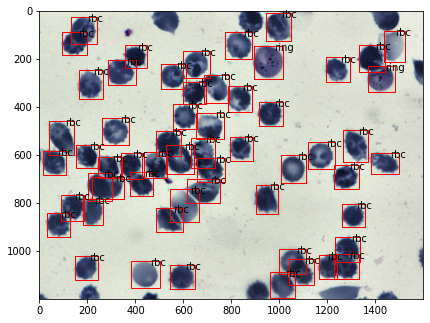

In [57]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

# Membaca gambar train dari google drive
image = plt.imread('drive/MyDrive/Visi Komputer/Images/train_images_dua.png')
plt.imshow(image)

# Menggunakan data dalam train.csv
for _,row in train[train.pathname=="/images/00c8364b-8c85-4502-bcfe-64736fe76815.png"].iterrows():
    xmin = row.bbminC
    xmax = row.bbmaxC
    ymin = row.bbminR
    ymax = row.bbmaxR
    
    l = xmax-xmin
    b = ymax-ymin
           
    if row.category=='red blood cell':
      color='r'
      ax.annotate('rbc',xy=(xmax-40,ymin+20))
    elif row.category=='trophozoite':
      color='g'
      ax.annotate('trpz',xy=(xmax-40,ymin+20))
    elif row.category=='difficult':
      color='b'
      ax.annotate('dfct',xy=(xmax-40,ymin+20))
    elif row.category=='ring':
      color='r'
      ax.annotate('ring',xy=(xmax-40,ymin+20))
    elif row.category=='schizont':
      color='r'
      ax.annotate('sznt',xy=(xmax-40,ymin+20))
    elif row.category==6:
      color='gametocyte'
      ax.annotate('gmct',xy=(xmax-40,ymin+20))
    elif row.category==5:
      color='leukocyte'
      ax.annotate('lkct',xy=(xmax-40,ymin+20))
    
    
    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)

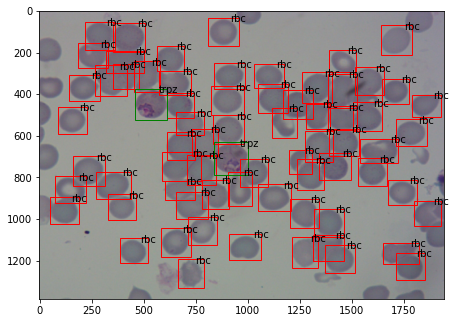

In [58]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

# Membaca gambar test dari google drive
image = plt.imread('drive/MyDrive/Visi Komputer/Images/test_images.jpg')
plt.imshow(image)

# Menggunakan data dalam test.csv
for _,row in test[test.pathname=="/images/deab75c9-00bc-488c-8b20-ff4515d85212.jpg"].iterrows():
    xmin = row.bbminC
    xmax = row.bbmaxC
    ymin = row.bbminR
    ymax = row.bbmaxR
    
    
    l = xmax-xmin
    b = ymax-ymin
           
    if row.category=='red blood cell':
      color='r'
      ax.annotate('rbc',xy=(xmax-40,ymin+20))
    elif row.category=='trophozoite':
      color='g'
      ax.annotate('trpz',xy=(xmax-40,ymin+20))
    elif row.category=='difficult':
      color='b'
      ax.annotate('dfct',xy=(xmax-40,ymin+20))
    elif row.category=='ring':
      color='r'
      ax.annotate('ring',xy=(xmax-40,ymin+20))
    elif row.category=='schizont':
      color='r'
      ax.annotate('sznt',xy=(xmax-40,ymin+20))
    elif row.category==6:
      color='gametocyte'
      ax.annotate('gmct',xy=(xmax-40,ymin+20))
    elif row.category==5:
      color='leukocyte'
      ax.annotate('lkct',xy=(xmax-40,ymin+20))
    
    
    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)

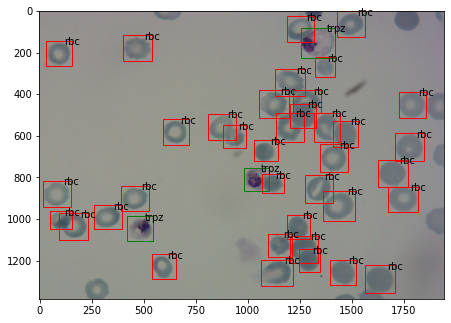

In [59]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

# Membaca gambar test dari google drive
image = plt.imread('drive/MyDrive/Visi Komputer/Images/test_images_dua.jpg')
plt.imshow(image)

# Menggunakan data dalam test.csv
for _,row in test[test.pathname=="/images/0a3b53c7-e7ab-4135-80aa-fd2079d727d6.jpg"].iterrows():
    xmin = row.bbminC
    xmax = row.bbmaxC
    ymin = row.bbminR
    ymax = row.bbmaxR
    
    
    l = xmax-xmin
    b = ymax-ymin
           
    if row.category=='red blood cell':
      color='r'
      ax.annotate('rbc',xy=(xmax-40,ymin+20))
    elif row.category=='trophozoite':
      color='g'
      ax.annotate('trpz',xy=(xmax-40,ymin+20))
    elif row.category=='difficult':
      color='b'
      ax.annotate('dfct',xy=(xmax-40,ymin+20))
    elif row.category=='ring':
      color='r'
      ax.annotate('ring',xy=(xmax-40,ymin+20))
    elif row.category=='schizont':
      color='r'
      ax.annotate('sznt',xy=(xmax-40,ymin+20))
    elif row.category==6:
      color='gametocyte'
      ax.annotate('gmct',xy=(xmax-40,ymin+20))
    elif row.category==5:
      color='leukocyte'
      ax.annotate('lkct',xy=(xmax-40,ymin+20))
    
    
    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)